# Note 
All tests are already conducted with QuantReg. In most cases, we decided for the optimal variables based on the MSPE of the 50% quantile, thus the quantile Loss of this quantile. Hence, these tests should lead to the same results as the corresponding tests conduced with OLS.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

from energy_consumption.feature_selection.extract import extract_all_features

## Optimal Length of Observations
Comparison based on MSE

Extract energydata and features for Quantile Regression
Include relevant data (based on knowledge January 20, 2024)

In [ ]:
energydata = extract_all_features.get_energy_and_features(quantRegFinal1=True)

# ensure all test datasets have same length
energydata_test1 = energydata[0:-500]
energydata_test2 = energydata[100:-400]
energydata_test3 = energydata[200:-300]
energydata_test4 = energydata[300:-200]
energydata_test5 = energydata[400:-100]
energydata_test6 = energydata[500:]

# quick test
len(energydata_test1) == len(energydata_test6)

### QuantReg Model for Energy Data based on its Time Series

Adjust length of training data set for final model, 
* shrunkate data set on upper front for different predictions
* evaluate models based on r_squared
* solely train for 50% Quantile for simplicity --> Basically the same results as OLS
* Decide based on R_squared

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

data = [energydata_test1, energydata_test2, energydata_test3, energydata_test4, energydata_test5, energydata_test6]

length_adjuster = [1, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7,
                   0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35,
                   0.3, 0.25, 0.2, 0.16, 0.1, 0.05]

max_length = len(energydata_test1)
r_squareds = {}
mspes = {}

for l in length_adjuster: 

    r_squared_l = []
    mspe_l = []
    
    for dataset in data: 

        # am oberen Ende kürzen --> unterschiedliche Forecasts
        energydata_temp = dataset[:int(l*max_length)]

        X = energydata_temp.drop(columns=['energy_consumption'])
        X.insert(loc=0, column='constant', value=1)
        y = energydata_temp['energy_consumption']

        X_train, X_test = X.iloc[:-100], X.iloc[-100:]
        y_train, y_test = y.iloc[:-100], y.iloc[-100:]

        # Initialize QuantReg model
        quantreg_model = sm.QuantReg(y_train, X_train)

        # Fit the initial model for 50% Quantile 
        quantreg_results = quantreg_model.fit(q=0.5)

        # Calculate R squared
        y_hat = quantreg_results.predict(X_train)
        y_mean = np.mean(y_train)
        r_squared = 1 - (np.sum((y_train - y_hat)**2) / np.sum((y_train - y_mean)**2))
        r_squared_l.append(r_squared)

        # Calculate MSPE
        y_pred = quantreg_results.predict(X_test)
        mspe = mean_squared_error(y_test, y_pred)
        mspe_l.append(mspe)

    print('----------l = ', l, '-----------')
    print("R_squared", r_squared_l)
    print("MSPE", mspe_l)

    r_squareds.update({l: r_squared_l})
    mspes.update({l: mspe_l})

In [ ]:
r_squared_summary = {}
mspe_summary = {}
for l in length_adjuster: 
    r_squared_summary[l] = np.mean(r_squareds[l])
    mspe_summary[l] = np.mean(mspes[l])

([<matplotlib.axis.XTick at 0x26b67920490>,
 [Text(0.1, 0, '6004'),
  Text(0.3, 0, '18012'),
  Text(0.5, 0, '30020'),
  Text(0.7, 0, '42029'),
  Text(0.9, 0, '54037')])

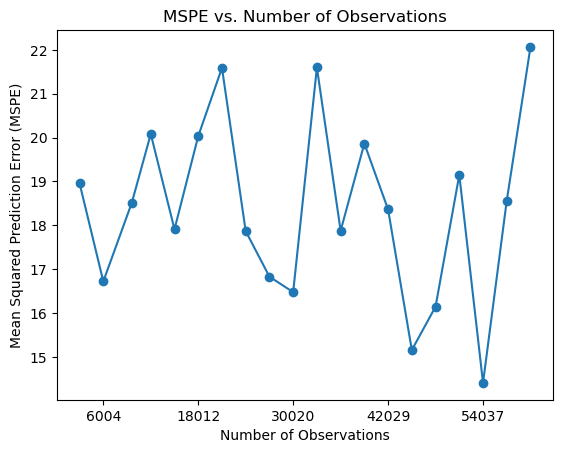

In [ ]:
# Extract keys and values from the dictionary
lengths = list(mspe_summary.keys())
mspe_values = list(mspe_summary.values())

# Plot the MSEs
plt.plot(lengths, mspe_values, marker='o')
plt.title('MSPE vs. Number of Observations')
plt.xlabel('Number of Observations')
plt.ylabel('Mean Squared Prediction Error (MSPE)')

xticks = [0.1 * 60041, 0.3 * 60041, 0.5 * 60041, 0.7 * 60041, 0.9 * 60041]
plt.xticks(ticks = [0.1, 0.3, 0.5, 0.7, 0.9], labels=[f'{val:.0f}' for val in xticks])

In [3]:
# R-Squared usually increases with number of observations, decide based on MSE, whereas no trend observable
opt_num_obs = 54027

### QuantReg Model for EnergyData based on Features
Focus on the subset of new features --> cluster dummies a little and include all new features to see how much they can explain

In [4]:
energydata = extract_all_features.get_energy_and_features(feature_selection=True)
energydata_fm = energydata[-opt_num_obs:]

X = energydata_fm.drop(columns=['energy_consumption'])
y = energydata_fm['energy_consumption']

2016-12-26 00:00:00
2023-11-23 12:00:00


We already know that seasonality plays a big role --> Dummies are probably highly significant 
Check last new features (sun hours, temperature, political instability, .. for significance and start with relatively high k due to computational time)

In [ ]:
# Perform time series split
tscv = TimeSeriesSplit(n_splits=5, test_size=100)

# Dictionary to store MSPE for different feature selections
mspes_fe = {}

# Define a function to perform RFE using QuantReg (eliminate features based on their p values)
def recursive_feature_elimination(X, y, n_features_to_select):
    selected_features = list(X.columns)
    while len(selected_features) > n_features_to_select:
        X = X[selected_features]
        X.insert(loc=0, column='constant', value=1)
        model = sm.QuantReg(y,X)
        results = model.fit(q=0.5)
        p_values = results.pvalues[1:]
        worst_feature = p_values.idxmax()
        print(selected_features)
        print(worst_feature)
        selected_features.remove(worst_feature)
    return selected_features

# Set the number of features you want to select
n_features_to_select = [1,2,3,4,5,6,7,8,9,
                        10,11,12,13,14,15, 16, 17]

for n in n_features_to_select:

    # Lists to store results for each split
    mspe_splits = []

    for train_index, test_index in tscv.split(X):
        
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Perform RFE using QuantReg
        selected_features_rfe = recursive_feature_elimination(
            X_train, y_train, n)

        # Train the final model using the selected features
        X_final = X_train[selected_features_rfe]
        X_final.insert(loc=0, column='constant', value=1)
        final_quantreg_model = sm.QuantReg(
            y_train, X_final)
        final_quantreg_results = final_quantreg_model.fit(q=0.5)

        # predict 50% quantile (mean)
        X_test_final = X_test[selected_features_rfe]
        X_test_final.insert(loc=0, column='constant', value=1)
        y_pred = final_quantreg_results.predict(X_test_final)

        # Evaluate model
        mspe = mean_squared_error(y_test, y_pred)
        mspe_splits.append(mspe)

    # Average MSPE across splits
    mspe_avg = np.mean(mspe_splits)

    print('----------n = ', n, '-----------')
    print("Average Mean Squared Error", mspe_avg)
    print('Selected_features: ', selected_features_rfe)

    # Store the results in the dictionary
    mspes_fe.update({n: mspe_avg})

In [ ]:
X.columns

Index(['period1', 'period2', 'period3', 'period4', 'period5', 'period6',
       'saturday', 'working_day', 'winter', 'spring_autumn', 'holiday',
       'abs_log_ret_weekly', 'sun_hours', 'tavg', 'wspd', 'index',
       'population'],
      dtype='object')

([<matplotlib.axis.XTick at 0x2ae35edc890>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17')])

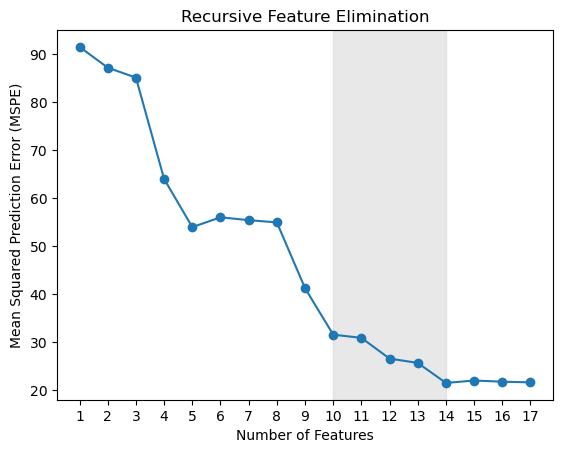

In [20]:
import matplotlib.pyplot as plt

# Extract keys and values from the dictionary
n_features = list(mspes_fe.keys())
mspe_values = list(mspes_fe.values())

# Plot the MSEs
plt.plot(n_features, mspe_values, marker='o')
plt.title('Recursive Feature Elimination')
plt.xlabel('Number of Features')
plt.ylabel('Mean Squared Prediction Error (MSPE)')
plt.axvspan(10, 14, color='lightgrey', alpha=0.5)
plt.xticks(range(min(n_features), max(n_features) + 1))

RFE shows: 
* n = 14 performs the best
* variables to exclude: population, spring_autumn, abs_log_ret_weekly
* no month/season mapping --> weather data better proxy

Select the following variables for quantile regression: 
* periods/hours
* days/ working days
* holidays 
* sun_hours
* tavg
* wspd
* index
Considerable: tavg, wspd

Lastly, compare quantile regression with all days, seasons and hours as dummies with aggregated data and left out wspd and tavg (corr of 0.75 with sun_hours, sun_hours deterministic and both show same correlation with ec:)

In [24]:
energydata_fm.corr()

,energy_consumption,period1,period2,period3,period4,period5,period6,saturday,working_day,winter,spring_autumn,holiday,abs_log_ret_weekly,sun_hours,tavg,wspd,index,population
energy_consumption,1.000000,0.135978,-0.493718,0.308092,-0.070569,0.059154,0.289666,-0.222000,0.453516,0.237242,-0.027695,-0.172829,-0.033139,-0.295561,-0.300580,0.150936,0.195585,-0.174425
period1,0.135978,1.000000,-0.093245,-0.133792,-0.078806,-0.062866,-0.078826,0.000115,-0.000093,0.000007,-0.000011,0.000002,-0.000001,0.000061,0.000094,-0.000012,0.000134,-0.000129
period2,-0.493718,-0.093245,1.000000,-0.286951,-0.169020,-0.134831,-0.169063,-0.000321,0.000241,0.000014,-0.000024,0.000005,0.000058,-0.000109,-0.000190,0.000071,-0.000290,0.000288
period3,0.308092,-0.133792,-0.286951,1.000000,-0.242518,-0.193463,-0.242580,0.000238,-0.000195,0.000020,-0.000035,0.000007,0.000009,0.000137,0.000208,-0.000018,0.000293,-0.000281
period4,-0.070569,-0.078806,-0.169020,-0.242518,1.000000,-0.113954,-0.142884,0.000049,-0.000044,0.000012,-0.000020,0.000004,0.000015,0.000043,0.000060,0.000005,0.000080,-0.000075
period5,0.059154,-0.062866,-0.134831,-0.193463,-0.113954,1.000000,-0.113982,-0.000025,0.000014,0.000009,-0.000016,0.000003,0.000019,0.000007,0.000004,0.000015,-0.000001,0.000004
period6,0.289666,-0.078826,-0.169063,-0.242580,-0.142884,-0.113982,1.000000,0.000140,-0.000062,-0.000083,0.000143,-0.000027,-0.000156,-0.000096,-0.000087,-0.000119,-0.000072,0.000046
saturday,-0.222000,0.000115,-0.000321,0.000238,0.000049,-0.000025,0.000140,1.000000,-0.645206,0.002126,-0.002185,-0.034138,-0.000020,0.000140,-0.002716,0.004835,-0.007277,0.000382
working_day,0.453516,-0.000093,0.000241,-0.000195,-0.000044,0.000014,-0.000062,-0.645206,1.000000,-0.003063,0.001018,0.052953,0.000531,-0.000027,0.003734,0.005015,0.011248,-0.000455
winter,0.237242,0.000007,0.000014,0.000020,0.000012,0.000009,-0.000083,0.002126,-0.003063,1.000000,-0.578965,0.050283,-0.072718,-0.654430,-0.583305,0.280932,-0.233030,-0.045191


In [12]:
# this time: compare based on mean pinball loss --> important result

from sklearn.metrics import mean_pinball_loss

energydata_agg = energydata_fm.drop(
    columns=['population','spring_autumn', 'abs_log_ret_weekly'])

# Perform time series split
tscv = TimeSeriesSplit(n_splits=5, test_size=100)

X = energydata_agg.drop(columns=['energy_consumption'])
y = energydata_agg[['energy_consumption']]
X.insert(loc=0, column='constant', value=1)

# Dictionary to store MSPE for different feature selections
scores_agg = {}
scores_spec = {}

quantiles = [0.025, 0.25, 0.5, 0.75, 0.975]
overall_score_agg = []

for train_index, test_index in tscv.split(X):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the final model using the selected features
    quantreg_model = sm.QuantReg(
            y_train, X_train)
    
    scores = []
    for q in quantiles: 

        # 50% quantile 
        model_results = quantreg_model.fit(q=q)
        y_pred = model_results.predict(X_test)
        score = mean_pinball_loss(y_test, y_pred, alpha=q)
        scores.append(score)
    
    overall_score_agg.append(np.mean(scores))

In [8]:
overall_score_agg

[0.9263126066692458,
 1.0421752293317912,
 0.9632849688061883,
 1.0178098228728187,
 0.9501135707558559]

In [10]:
energydata_spec = extract_all_features.get_energy_and_features(
    feature_selection_comp=True)[-opt_num_obs:]

# Perform same time series split
tscv = TimeSeriesSplit(n_splits=5, test_size=100)

X = energydata_spec.drop(columns=['energy_consumption'])
y = energydata_agg[['energy_consumption']]
X.insert(loc=0, column='constant', value=1)

quantiles = [0.025, 0.25, 0.5, 0.75, 0.975]
overall_score_spec = []

for train_index, test_index in tscv.split(X):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    quantreg_model = sm.QuantReg(
        y_train, X_train)

    scores = []
    for q in quantiles:
        model_results = quantreg_model.fit(q=q)
        y_pred_agg = model_results.predict(X_test)
        score = mean_pinball_loss(y_test, y_pred)
        scores.append(score)

    overall_score_spec.append(np.mean(scores))

2016-12-26 00:00:00
2023-11-23 12:00:00


c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


In [11]:
overall_score_spec

[6.417965744431473,
 5.458116134369174,
 6.344934895122455,
 4.26275274903196,
 2.8771933194815147]

Significantly better performance of the aggregated model when it comes to quantile scores!!